In [82]:
%%html 
<link rel="stylesheet" href="http://bit.ly/1DxvcrA">

In [83]:
# imports
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# this allows plots to appear directly in the notebook
%matplotlib inline
plt.style.use('fivethirtyeight')    


## Importing and exploring the data
----
## About this dataset
- real order data from ~30,000 grocery delivery orders completed in Feb and March 2015
- after order is completed, customers are prompted to rate their experience from 1 to 5 stars, with 5 being the best. Customers are not required to rate.
- each order should be delivered within a 1-hour window, e.g. 5pm-6pm
- early orders = delivered before the start of that window
- late orders = delivered after window end
- on time orders = delivered at any point within the 1-hour window

## Objective
- Use logistic regression model to determine which variables are most correlated with negative customer experiences, i.e. which features of a given order are likely to result in a higher rating.
- For the purposes of this analysis, I have created a binary target in which a customer rating is categorized as either 5 stars or not 5 stars.

## Features:
- ***minutes_late:*** minutes after end of window (int)
- ***minutes_early:*** minutes before start of window (int)
- ***on_time:*** delivered within window (bool)
- ***fifteen_early:*** delivered btw 0-15 minutes early (bool)
- ***very_early:*** delivered >15 minutes early (bool)
- ***fifteen_late:*** delivered btw 0-15 minutes late (bool)	
- ***very_late:*** delivered >15 minutes late (bool)
- ***has_issue:***: order contained one or more complaint from customer (bool) 	
- ***charge:*** transaction amount, $ (int)
- ***batch_type:*** order executed by a single worker, or a handoff between two workers (string)
- ***order_num:***	ordinal number of order for customer, e.g. 3 = third order for that customer
- ***rating:*** customer rating 1-5 stars. 0 = not rated (int)
- ***refunded:*** pct of grocery items not found in store and refunded to customer (float)	
- ***replaced:*** pct of grocery items not found in store and replaced with similar item (float)		
- ***target:*** was order <5 stars (bool)


In [84]:
# read data into a DataFrame
data = pd.read_csv('data/regression-data-wn.csv', index_col=0)

# add target column for rating < 5 stars
data['target'] = data['rating'].map(lambda x: 1 if x == 5 else 0)

# decided to remove all categorial variables for sake of simiplicity
data = data.drop(['zone_id', 'warehouse', 'batch_type'], axis=1)

data.head()

,minutes_late,minutes_early,on_time,fifteen_early,very_early,fifteen_late,very_late,has_issue,charge,order_num,rating,refunded,replaced,target
id,,,,,,,,,,,,,,
234770763,0,117.599508,0,0,1,0,0,0,28.90,86,0,0.000000,0.000000,0
234728379,0,86.596930,0,0,1,0,0,0,58.44,9,4,0.125000,0.000000,0
234802232,0,82.364777,0,0,1,0,0,0,122.70,9,5,0.000000,0.173913,1
234709073,0,82.161657,0,0,1,0,0,0,113.11,10,5,0.000000,0.000000,1
234696535,0,81.416833,0,0,1,0,0,0,88.64,1,0,0.285714,0.000000,0


In [85]:
data.describe()

,minutes_late,minutes_early,on_time,fifteen_early,very_early,fifteen_late,very_late,has_issue,charge,order_num,rating,refunded,replaced,target
count,29124.000000,29124.000000,29124.000000,29124.000000,29124.000000,29124.000000,29124.000000,29124.000000,29113.000000,29113.000000,29113.000000,29113.000000,29113.000000,29124.000000
mean,3.050731,2.729364,0.679749,0.118047,0.072895,0.066921,0.062388,0.108673,102.796572,11.131350,1.841651,0.099909,0.109799,0.280731
std,12.986468,7.789016,0.466581,0.322669,0.259969,0.249889,0.241864,0.311234,72.745299,16.905641,2.252445,0.118427,0.121104,0.449364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.630000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.540000,5.000000,0.000000,0.071429,0.086957,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,128.750000,13.000000,5.000000,0.153846,0.166667,1.000000
max,289.614104,117.599508,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1190.680000,224.000000,5.000000,1.000000,1.000000,1.000000


In [86]:
data.groupby('rating').mean()

,minutes_late,minutes_early,on_time,fifteen_early,very_early,fifteen_late,very_late,has_issue,charge,order_num,refunded,replaced,target
rating,,,,,,,,,,,,,
0,3.024465,2.841882,0.675447,0.119200,0.076215,0.066337,0.062801,0.049692,104.627646,12.264679,0.097978,0.110307,0
1,7.012277,2.246625,0.632427,0.114804,0.064451,0.083585,0.104733,0.710977,107.363061,8.626385,0.198624,0.098361,0
2,5.739660,2.730798,0.662757,0.098240,0.071848,0.065982,0.101173,0.697947,103.114252,8.851906,0.176871,0.105870,0
3,4.641533,2.504509,0.645070,0.112676,0.063850,0.083568,0.094836,0.540845,109.463305,9.901408,0.149265,0.105891,0
4,3.008725,2.835681,0.663140,0.126392,0.071826,0.071269,0.067372,0.231069,101.676860,8.233853,0.110162,0.120333,0
5,2.176240,2.570644,0.703889,0.116683,0.068860,0.062867,0.047701,0.021649,97.919897,10.148973,0.076693,0.108693,1


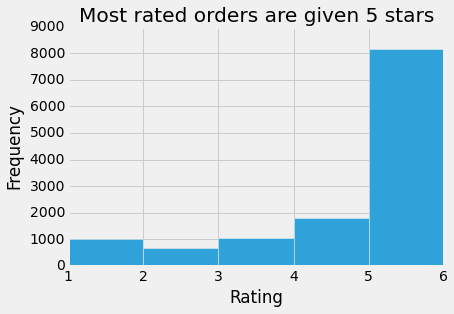

In [87]:
# drop non-rated orders. will use this dataset going forward.
rated_orders = data[data.rating > 0]
#rated_orders.describe()
# explore distribution of rated orders
rated_orders.rating.plot(kind='hist', bins=[1,2,3,4,5,6])
plt.title('Most rated orders are given 5 stars')
plt.xlabel('Rating')
plt.ylabel('Frequency')

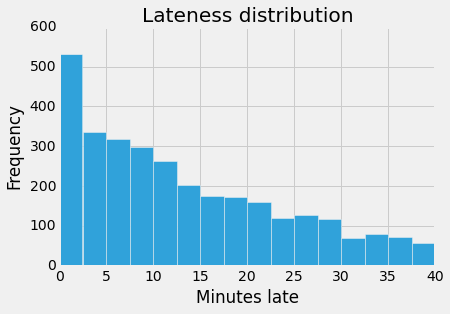

In [88]:
# explore lateness of all orders...guessing this has highest correlation
late_orders = data[data.minutes_late > 0]

late_orders.minutes_late.plot(kind='hist', bins=[0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30,32.5,35,37.5,40])
plt.title('Lateness distribution')
plt.xlabel('Minutes late')
plt.ylabel('Frequency')

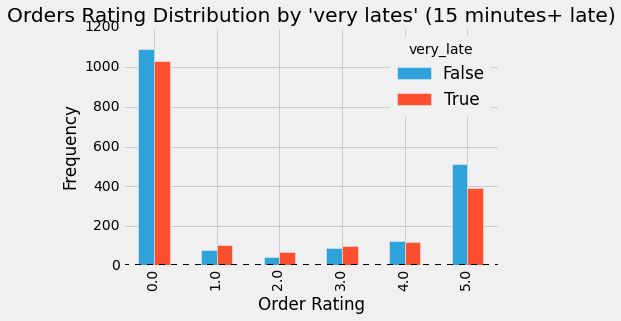

In [89]:
# barplot of rating by very late (15+ minutes late) (True or False)
pd.crosstab(late_orders.rating, late_orders.very_late.astype(bool)).plot(kind='bar')
plt.title('Orders Rating Distribution by \'very lates\' (15 minutes+ late)')
plt.xlabel('Order Rating')
plt.ylabel('Frequency')

## Preparing for logistic regression

In [90]:
from patsy import dmatrices

# drop ratings column from rated_orders for collinearity
lm_rated_orders = rated_orders.drop(['rating'], axis=1)

# create dataframes with an intercept column
y, X = dmatrices('target ~ minutes_late	+ minutes_early	+ on_time + \
                  fifteen_early + very_early + fifteen_late + very_late + \
                  has_issue + charge + order_num + refunded + replaced',
                  lm_rated_orders, return_type="dataframe")

# confirm columns and target
print(X.columns)
print(y.head(5))

Index([u'Intercept', u'minutes_late', u'minutes_early', u'on_time', u'fifteen_early', u'very_early', u'fifteen_late', u'very_late', u'has_issue', u'charge', u'order_num', u'refunded', u'replaced'], dtype='object')
           target
id               
234728379       0
234802232       1
234709073       1
234814367       0
234770510       1


In [91]:
# flatten y into a 1-D array
y = np.ravel(y)

In [92]:
# make logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check accuracy on the training set
model.score(X, y)

0.80144745122718686

In [93]:
# what percentage rated 5 stars? score needs to be better than this. it is.
y.mean()

0.64317180616740088

In [94]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.764622313128]
1,minutes_late,[-0.0105279635238]
2,minutes_early,[-0.0144684147079]
3,on_time,[0.216400217382]
4,fifteen_early,[0.222994452116]
5,very_early,[0.468565207281]
6,fifteen_late,[-0.000605822406652]
7,very_late,[-0.142731741244]
8,has_issue,[-3.61055827667]
9,charge,[7.34884701837e-05]


## Initial evaluation
- On time and early orders most positively correlate to a 5 star rating
- Customer complaints and the percentage of replaced order items most negatively correlate to customer rating

## Model evaluation

In [95]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
                                                    random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [96]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)


[ 1.  1.  1. ...,  1.  0.  1.]


In [97]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print(probs)

[[ 0.1419621   0.8580379 ]
 [ 0.45655742  0.54344258]
 [ 0.22485191  0.77514809]
 ..., 
 [ 0.22868963  0.77131037]
 [ 0.94289318  0.05710682]
 [ 0.34940978  0.65059022]]


In [98]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
#area under curve
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.800996329313
0.816290154945


In [99]:
# confusion matrix
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[ 690  680]
 [  79 2365]]
             precision    recall  f1-score   support

        0.0       0.90      0.50      0.65      1370
        1.0       0.78      0.97      0.86      2444

avg / total       0.82      0.80      0.78      3814



## Evaluate logistic regression Model  Using Cross-Validation


In [100]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.78459119  0.7586478   0.43553459  0.79166667  0.80896226  0.80031447
  0.8007874   0.80314961  0.8015748   0.80787402]
0.75931028079


#Decision Tree classifer

In [101]:
from sklearn import feature_extraction
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.core.display import Image
import pydot

import sys
sys.path.append('/usr/lib/graphviz/python/')    # 32-bits
sys.path.append('/usr/lib64/graphviz/python/')  # 63-bits

from __future__ import print_function

In [102]:
dataclf = lm_rated_orders.dropna()
dataclf = dataclf.drop('charge', axis=1)
# Split the data set in features and labels
features = X = dataclf.drop(['target'], axis=1)
labels = y = dataclf.target

test_features = features[-1:]
test_label = labels[-1:]

# Train the decision tree based on the entropy criterion
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(features[:-1], labels[:-1])
clf

DecisionTreeClassifier(compute_importances=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')

In [103]:
dataclf.describe()

,minutes_late,minutes_early,on_time,fifteen_early,very_early,fifteen_late,very_late,has_issue,order_num,refunded,replaced,target
count,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000
mean,3.069343,2.585830,0.685415,0.116583,0.068675,0.067574,0.061753,0.184865,9.669132,0.102401,0.109144,0.643172
std,13.196158,7.531821,0.464369,0.320935,0.252911,0.251023,0.240715,0.388203,15.127763,0.119706,0.116004,0.479082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.071429,0.090909,1.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.153846,0.166667,1.000000
max,289.614104,86.596930,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,196.000000,1.000000,1.000000,1.000000


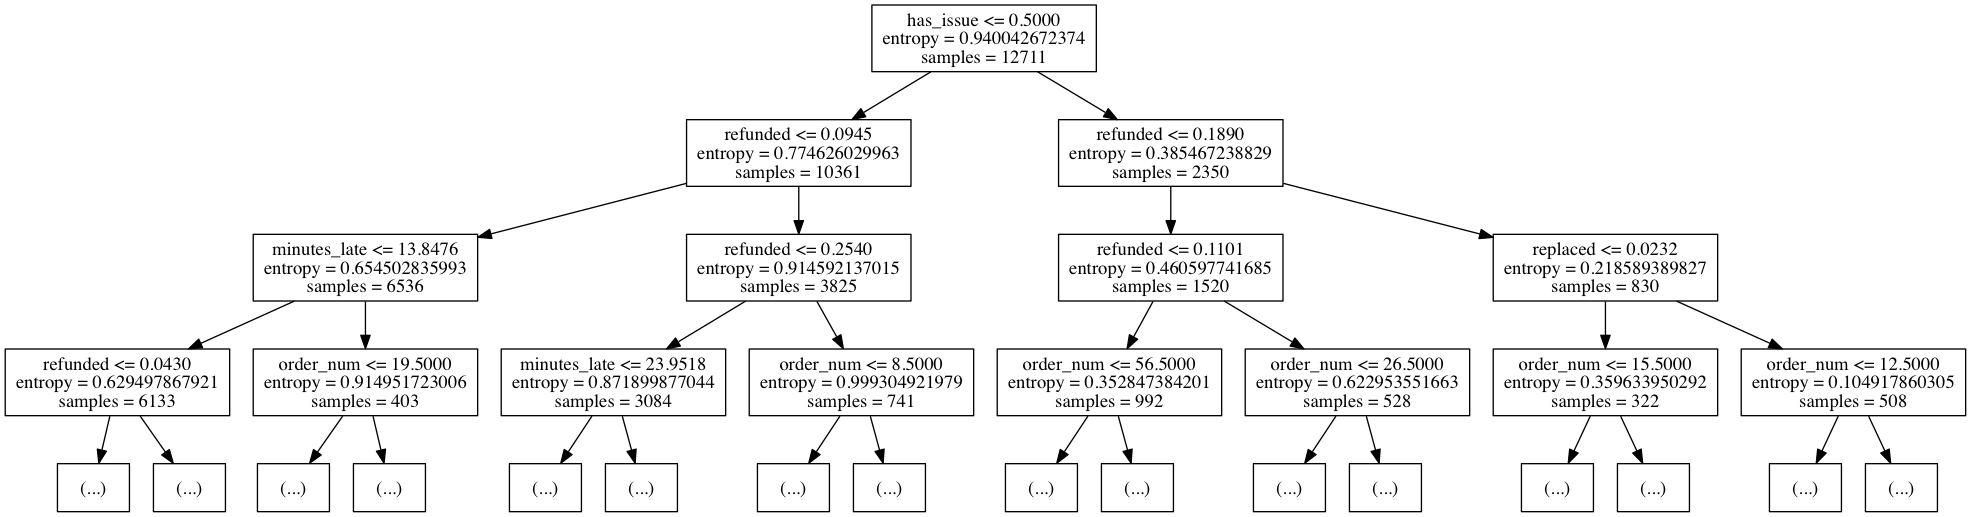

In [113]:
# Visualize the decision tree
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=features.columns, max_depth=3) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [105]:
# Make a single prediction with test data
pred = clf.predict(test_features)
print(features[-1:].T)
print('Predicted class:', pred)
print('Accurate prediction?', pred[0] == test_label.values[0])

id             234669459
minutes_late    0.000000
minutes_early   0.000000
on_time         1.000000
fifteen_early   0.000000
very_early      0.000000
fifteen_late    0.000000
very_late       0.000000
has_issue       0.000000
order_num       4.000000
refunded        0.058824
replaced        0.058824
Predicted class: [1]
Accurate prediction? True


In [106]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier


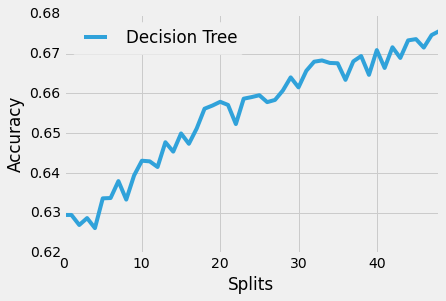

In [107]:
## evaluate DecisionTreeClassifier
dtc_scores = []
for i in range(1, 50):
    dtclf = DecisionTreeClassifier(max_depth=None, min_samples_split=i,
       random_state=0)
    dtclf.fit(X, y)
    scores = cross_val_score(dtclf, X, y)
    dtc_scores.append(scores.mean())
    #print(i, scores.mean())
    
df = pd.DataFrame({'Decision Tree': dtc_scores})
df.plot()
plt.xlabel('Splits')
plt.ylabel('Accuracy')

In [108]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.66666667  0.55031447  0.41352201  0.64701258  0.74056604  0.73977987
  0.72913386  0.7519685   0.74251969  0.7511811 ]
0.673266478483


In [109]:
print(y.mean())

0.643171806167


##Evaluate test set using decision tree

In [110]:
# declare DTC model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# predict class labels for the test set
y_pred = model.predict(X_test)
print(y_pred)

[ 1.  0.  1. ...,  0.  0.  0.]


In [111]:
# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 844  526]
 [ 534 1910]]
             precision    recall  f1-score   support

        0.0       0.61      0.62      0.61      1370
        1.0       0.78      0.78      0.78      2444

avg / total       0.72      0.72      0.72      3814



## Conclusion
### The features most detrimental to customer rating are, in order: 

1. Refund rate: customers do not like when a large percentage of the items in their order are out of stock and not delivered.
2. Has issue, i.e. customer complained. This is self-selecting...customers who complained are probably more likely to rate poorly.
3. Percent of items replaced. Surprisingly, this was more damaging that orders that are very late.
4. Very late (15+ minutes)

## Model evaluation
- I was able to achieve an accuracy score of 80% using the logistic regression model
- I then attempted to use a decision tree classifier, since the target was categorical. I was only able to achieve an accurary score of 67.3% using this model. This is very poor, given that mean value of the target is 64.3%

## OLS regression summary

In [112]:
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     690.4
Date:                Mon, 25 May 2015   Prob (F-statistic):               0.00
Time:                        22:18:58   Log-Likelihood:                -5923.5
No. Observations:               12712   AIC:                         1.187e+04
Df Residuals:                   12701   BIC:                         1.195e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
minutes_late     -0.0017      0.000     -4.130      0.000        -0.003    -0.001
minutes_early    -0.0023      0.001     -2.205      0.027        -0.004    -0.000
on_time           0.8519      0.007    127.578      0.000         0.839     0.865
fifteen_early     0.8531      0.013     63.803      0.000         0.827     0.879
very_early        0.8944      0.031     28.802      0.000         0.834     0.955
fifteen_late      0.8192      0.014     56.719      0.000         0.791     0.848
very_late         0.7942      0.023     34.529      0.000         0.749     0.839
has_issue        -0.6459      0.009    -70.902      0.000        -0.664    -0.628
order_num         0.0015      0.000      6.433      0.000         0.001     0.002
refunded         -0.6577      0.030    -22.049      0.000        -0.716    -0.599
replaced         -0.2025      0.030     -6.790      0.000        -0.261    -0.144
==============================================================================
Omnibus:                     1523.765   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2138.241
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                       3.218   Cond. No.                         188.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""